In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat
np.set_printoptions(precision=2)
plt.rcParams.update({'font.size': 26})

In [2]:
def get_CM(CH, CA, M, H, H1=10):
    """
    returns a full contact matrix M*H \times M*H
    Paramets
    CH: home contacts
    CA: away contacts
    M: age-groups
    H: number of house
    H1: # of household contact per 1000
    """
    C = np.zeros((M*H, M*H))

    for i in range(H):
        for j in range(H):
            if i==j:
                for ii in range(M):
                    for jj in range(M):
                        # diagonal block matrices
                        C[i*M+ii, j*M+jj] = CH[ii, jj]
            else:
                if np.random.randint(1000)<H1:  #+np.random.randint(10)
                    for ii in range(M):
                        for jj in range(M):
                            C[i*M+ii, j*M+jj] = CA[ii, jj]
    return C


def get_data(contactMatrix, x0, Ni, kI):
    beta  = 0.002              # probability of infection on contact 
    gI    = 1./10              # removal rate of asymptomatic infectives 
    

    parameters = {'beta':beta, 'gI':gI, 'kI':kI}
    model = pyross.deterministic.SIkR(parameters, Ni.size, Ni)

    
    # start simulation
    Tf, Nf = 90, 90; 
    data = model.simulator(x0, contactMatrix, Tf, Nf, integrator='odespy')
    return model.I(data), model.R(data)

## Varying contact matrices to study the full lockdown

In [3]:
M = 2        # two age groups
H = 512      # number of meta-houses
Hc = 20      # number of household contact per 1000
kI = 16      # number of stages of the SIkR model

Ni = np.zeros(M*H)
Ni[0::M]=5
Ni[1::M]=5


# initial conditions  
fI = 50 # every 50th house is infected
I0 = np.zeros((M*H*kI));   I0[0::M*kI*fI]=5;   I0[1::M*kI*fI]=5;
S0 = Ni - I0[0::kI];   x0 = np.concatenate((S0, I0))

In [4]:
CH = np.array(( [3., 1.], [1., 2.] ))
CA = np.array(( [12., 1.], [1., 3.] ))
C = get_CM(CH, CA, M, H, Hc)
C1 = get_CM(CH, 0*CA, M, H, Hc)

def contactMatrix(t):   
    return C
I1, R1  = get_data(contactMatrix, x0, Ni, kI)


def contactMatrix(t):   
    if t<20:
        return C
    elif 20<=t<40:
        return C1
    else:
        return C
I2, R2  = get_data(contactMatrix, x0, Ni, kI)

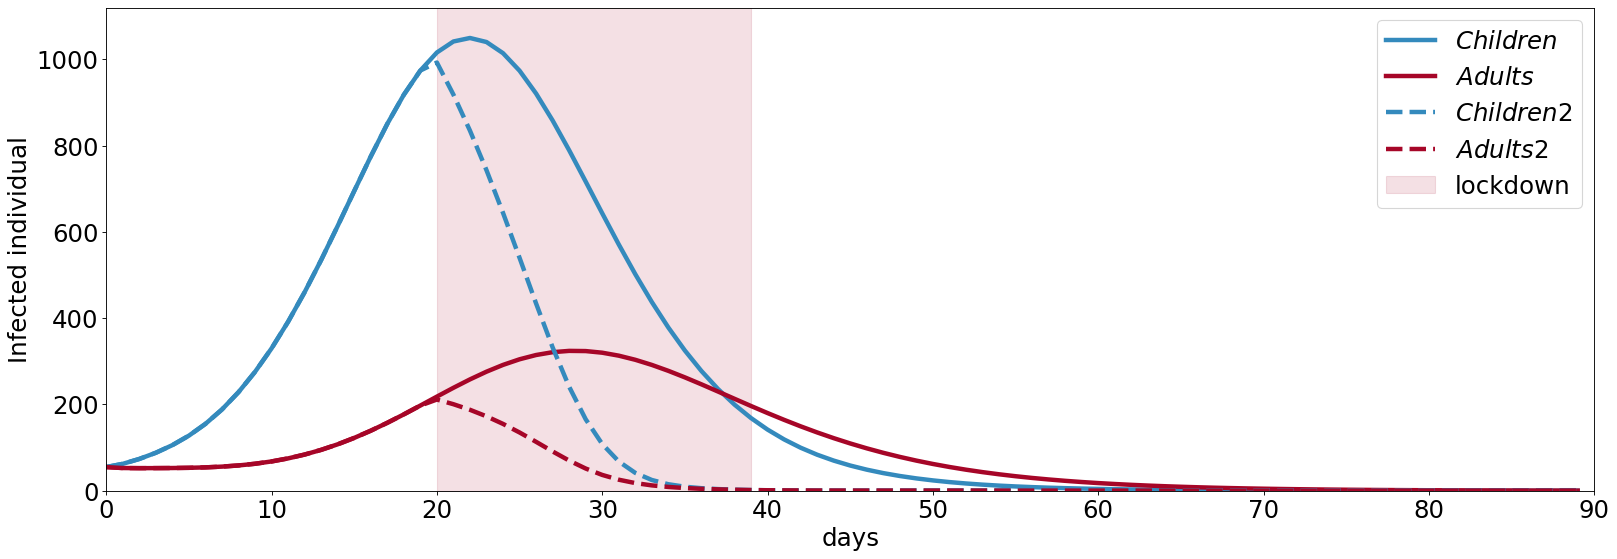

In [9]:
fig = plt.figure(num=None, figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(np.sum(I1[:,0::M], axis=1), '-', color="#348ABD", label='$Children$', lw=4)
plt.plot(np.sum(I1[:,1::M], axis=1), '-', color='#A60628', label='$Adults$', lw=4)

plt.plot(np.sum(I2[:,0::M], axis=1), '--', color="#348ABD", label='$Children2$', lw=4)
plt.plot(np.sum(I2[:,1::M], axis=1), '--', color='#A60628', label='$Adults2$', lw=4)

plt.fill_between(range(20,40), 0, 1200, color="#A60628", alpha=0.12, label='lockdown')

plt.legend();  plt.ylim(0, 1120); plt.xlim(0, 90)
plt.ylabel('Infected individual'); plt.xlabel('days');

In [6]:
print ('Childs, case 1', np.sum(R1[-1][0::M]))
print ('Childs, case 2', np.sum(R2[-1][0::M]))
print()
print ('Adults, case 1', np.sum(R1[-1][1::M]))
print ('Adults, case 2', np.sum(R2[-1][1::M]))

Childs, case 1 2241.3983422899078
Childs, case 2 1445.8855395996143

Adults, case 1 879.4084286339962
Adults, case 2 301.66777452358036
